In [8]:
# Plot one spectrum from each observation and each detector
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
#!ls ../../../data/Crires/BDs-DRACS/2017/HD30501-1/Combined_Nods/
import numpy as np

from spectrum_overload import Spectrum
from mingle.utilities.phoenix_utils import load_phoenix_spectrum


In [2]:
# Load telluric function

In [9]:

def load_telluric(path, filename):
    """Load in TAPAS telluric data and header.

    If just want the data then call as load_telluric()[0]
    or data, __ = load_telluric()

    Likewise just the header as hdr = load_telluric()[1].

    """
    ext = filename[-4:]
    file_ = path + filename
    if ext == "ipac":
        tell_hdr = fits.Header()
        with open(file_) as f:
            col1 = []
            col2 = []
            for line in f:
                if line.startswith("\\"):
                    # Get the Tapas Header
                    line = line[1:]  # remove the leading \
                    line = line.strip()
                    items = line.split("=")

                    tell_hdr[items[0]] = items[1]  # Add to header

                elif line.startswith("|"):
                    # Obtain wavelength scale from piped lines
                    if "in air" in line:
                        tell_hdr["WAVSCALE"] = "air"
                    elif "nm|" in line:
                        tell_hdr["WAVSCALE"] = "vacuum"
                    # Need extra condition to deal with wave number
                else:
                    line = line.strip()
                    val1, val2 = line.split()
                    col1.append(float(val1))
                    col2.append(float(val2))

    elif ext == "fits":
        i_tell = fits.getdata(file_, 1)
        tell_hdr = fits.getheader(file_, 1)
        # TODO ... Need to get wavelength scale (air/wavelength) from fits file somehow...
        col1 = i_tell["wavelength"]
        col2 = i_tell["transmittance"]

    else:
        raise ValueError("Tapas file '{0}' Does not have an extension of '.ipac' or '.fits'".format(filename))

    # Sort in ascending wavelength
    if col1[-1] - col1[0] < 0:  # wl is backwards
        col1 = col1[::-1]
        col2 = col2[::-1]
    tell_data = np.array([col1, col2], dtype="float64")

    return tell_data, tell_hdr

In [10]:
#!ls ../../../data/Crires/BDs-DRACS/2017/HD30501-1/Combined_Nods/
#!ls ../../../data/Crires/BDs-DRACS/2017/HD30501-1/Telluric_files/

In [11]:
# dir 
folder = "/home/jneal/Phd/data/Crires/BDs-DRACS/2017/"
observations = ["HD211847-1", "HD211847-2"]
chips = [1,2,3,4]



In [19]:
import simulators
simulators.starfish_grid["raw_path"] = "/home/jneal/Phd/data/PHOENIX-ALL/PHOENIX"
phoenix_name = "/home/jneal/Phd/data/PHOENIX-ALL/PHOENIX/Z-0.0/lte05700-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits"
star_spec = load_phoenix_spectrum(phoenix_name, limits=[2100, 2170], normalize=True)

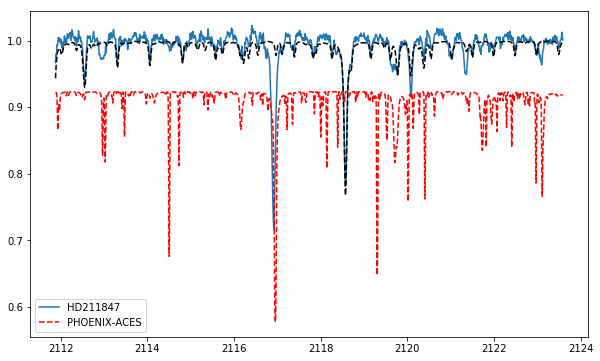

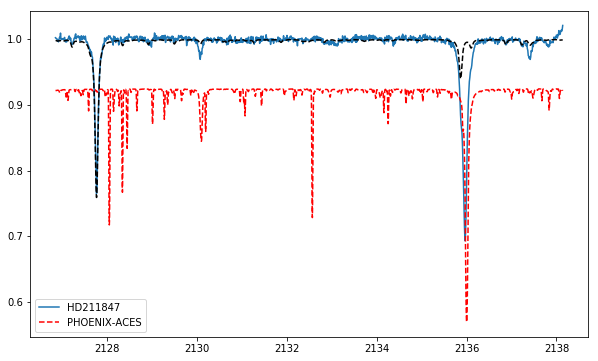

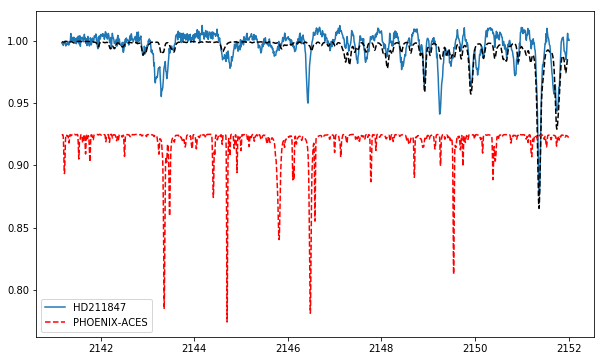

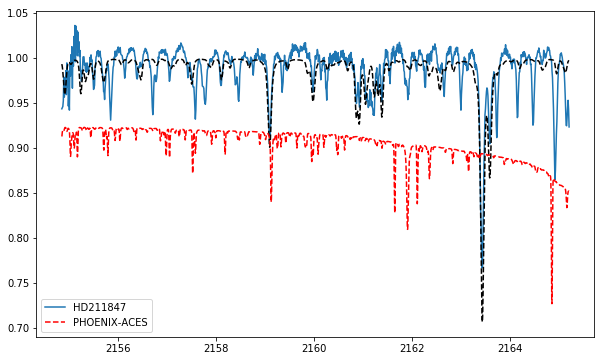

In [28]:
for chip in chips:    
    plt.figure(figsize=(10,6))
    spectrum = "CRIRE.2012*_{0}.nod.ms.norm.mixavg.wavecal.fits".format(chip) 
    for ii, observation in enumerate(observations):
        file = glob.glob(os.path.join(folder, observation, "Combined_Nods", spectrum))
        data = fits.getdata(file[0])
        
        telluric = glob.glob(os.path.join(folder, observation,
                                          "Telluric_files",
                                          "tapas*_ReqId_10_R-50000_sratio-10_barydone-NO*.ipac"))
        #print(telluric)
        assert len(telluric) == 1
        telluric_data, tell_header = load_telluric("", telluric[0])
        
        tell_spec = Spectrum(xaxis=telluric_data[0], flux=telluric_data[1])
        tell_spec.wav_select(data["Wavelength"][0], data["Wavelength"][-1])
        
        plt.plot(data["Wavelength"], data["Flux"] + 0.2*ii, label = observation.split("-")[0])
        plt.plot(tell_spec.xaxis, tell_spec.flux + 0.2*ii, "k--" )
     
    chip_star_spec = star_spec.copy()
    chip_star_spec.wav_select(data["Wavelength"][0], data["Wavelength"][-1])
    plt.plot(chip_star_spec.xaxis, chip_star_spec.flux + 0.2*(ii), "r--", label="PHOENIX-ACES" )
    plt.legend()
        

In [22]:
# Mask section code

In [29]:
folder = "/home/jneal/Phd/data/Crires/BDs-DRACS/2017/"
observations = ["HD211847-2"]
chips = [1,2,3,4]

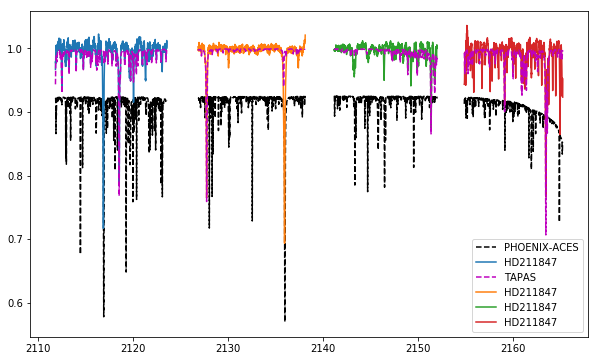

In [34]:
plt.figure(figsize=(10,6))
for chip in chips:    
    spectrum = "CRIRE.2012*_{0}.nod.ms.norm.mixavg.wavecal.fits".format(chip) 
    for ii, observation in enumerate(observations):
        file = glob.glob(os.path.join(folder, observation, "Combined_Nods", spectrum))
        data = fits.getdata(file[0])
        
        telluric = glob.glob(os.path.join(folder, observation,
                                          "Telluric_files",
                                          "tapas*_ReqId_10_R-50000_sratio-10_barydone-NO*.ipac"))
        #print(telluric)
        assert len(telluric) == 1
        telluric_data, tell_header = load_telluric("", telluric[0])
        
        tell_spec = Spectrum(xaxis=telluric_data[0], flux=telluric_data[1])
        tell_spec.wav_select(data["Wavelength"][0], data["Wavelength"][-1])
     
        chip_star_spec = star_spec.copy()
        chip_star_spec.wav_select(data["Wavelength"][0], data["Wavelength"][-1])
        plt.plot(chip_star_spec.xaxis, chip_star_spec.flux + 0.2*(ii), "k--", label="PHOENIX-ACES" )
        
        plt.plot(data["Wavelength"], data["Flux"] + 0.2*ii, label = observation.split("-")[0])
        plt.plot(tell_spec.xaxis, tell_spec.flux + 0.2*ii, "m--" , label="TAPAS")
 
        plt.legend()
        